In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import func as func  # func.py is in the same directory with this file

In [2]:
symbol = "BTCUSDT"  # code of Bitcoin
interval = "1h"  # time interval
start_date = "2025-01-01"
end_date = "2025-09-01"

df = func.get_klines(symbol, interval, start_date, end_date)  # download data
df = df[['open_time', 'close_time', 'close', 'high', 'low']]  # choose fields
df[['close', 'high', 'low']] = df[['close', 'high', 'low']].astype(float)  # transfer data type from str to float

In [3]:
period = 14
macd_span = [12, 26, 9]

df = func.compute_adx(df, period)  # compute ADX
df['RSI'] = func.compute_rsi(df['close'], period=period, ema=True)  # compute RSI
df['BB_sma'], df['BB_up'], df['BB_low'] = func.compute_bbands(
    df['close'], window=period)  # compute bollinger bands, keep window same as period of RSI
df['MACD'], df['signal'], df['histogram'] = func.compute_macd(df['close'], macd_span)  # compute MACD

In [68]:
def test(df, param, strategy):
    valid_index = max(df['ADX'].first_valid_index(), df['RSI'].first_valid_index())
    df = df[df.index >= valid_index].reset_index(drop=True)  # start from the line that all indicators are not nan
    if strategy == 'rsi':
        trades, account = func.rsi_only(df, param)  # exercise strategy and use [trades, account] to record
    if strategy == 'rsi_bbands':
        trades, account = func.rsi_bbands(df, param)
    if strategy == 'rsi_bbands_macd':
        trades, account = func.rsi_bbands_macd(df, param)
    account, summary = func.performance_assessment(account, freq='hourly')
    print(summary)
    func.plot_nav(account)
    
    return trades, account, summary

In [99]:
param = {
    'capital': 10000,  # initial capital
    'position': 0.0,  # initial position
    'stop': [1, -1],  # stop profit/loss
    'slippage': 0.001,
    'commision': 0.001,
    'trade_ratio': 0.2,  # 
    'adx_threshold': [20, 25],
    'rsi_threshold': [30, 70],
    'rsi_up': [35, 75],
    'rsi_down': [25, 65],
    'rsi_breakthrough': [50, 50],
    'bb_threshold': [1, 1]
}  # parameters of strategy

** RSI Only Strategy **

- The distribution of RSI resembles noise, with large fluctuations. And after breaking through the boundaries, it quickly reverts, resulting in the generation of ineffective trading signals

100%|██████████| 5807/5807 [00:06<00:00, 958.08it/s] 


   annual_return       NAV  max_drawdown  sharpe_ratio
0       0.160858  1.103932     -0.143575      0.758609


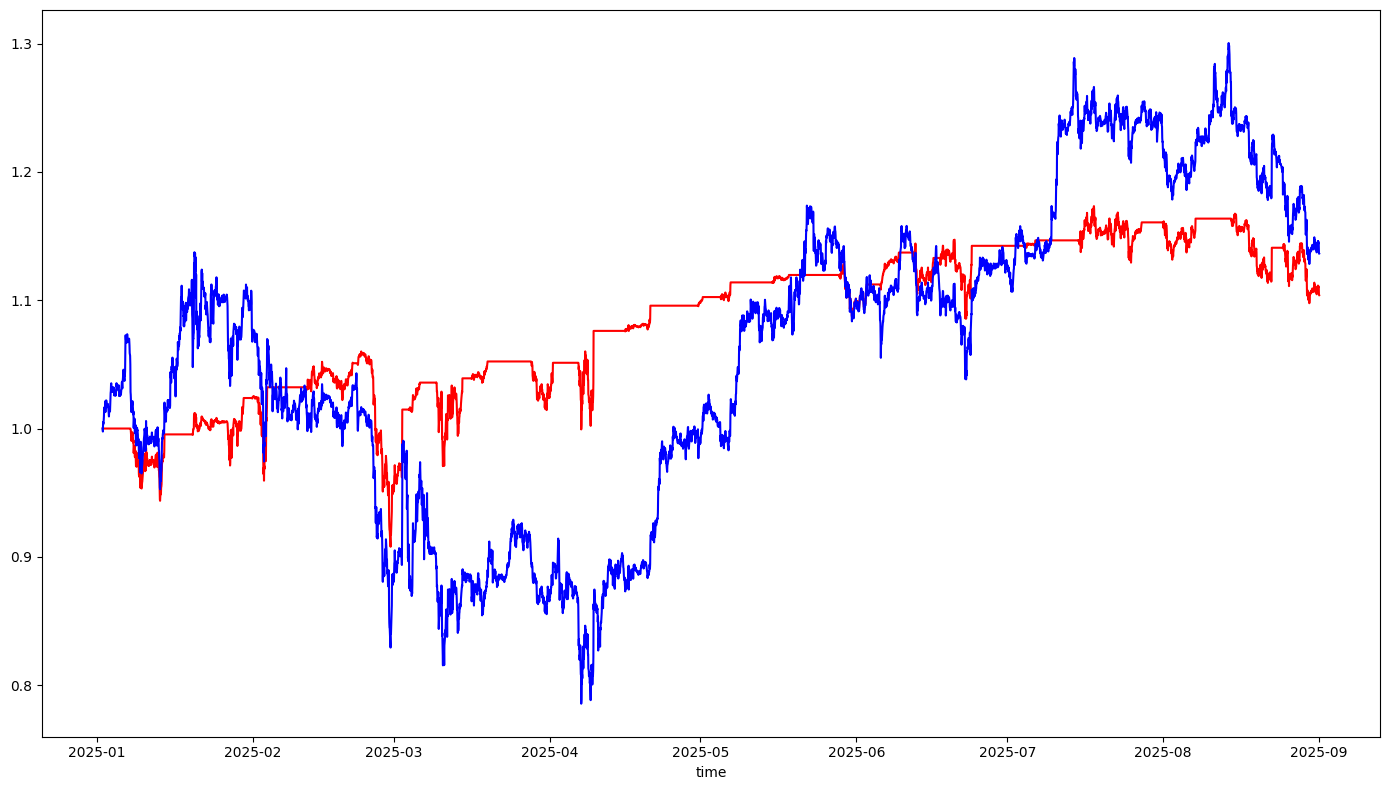

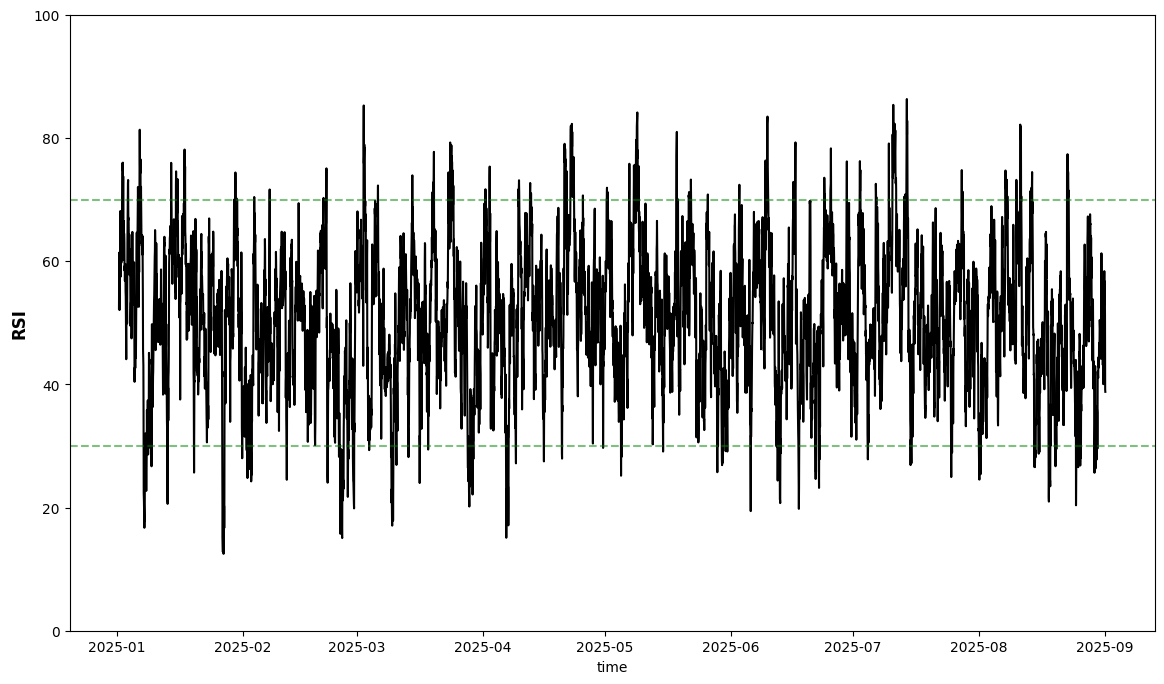

In [6]:
trades_r, account_r, summary_r = test(df, param, strategy='rsi')
func.plot_rsi(df, param)

** RSI_BBands_Strategy **

- Using RSI alone generates many invalid signals, Bollinger Bands were introduced to provide dual confirmation of RSI-based trading signals.
- Specifically, when RSI indicates oversold conditions and the price breaks below the lower Bollinger Band, positions are increased; conversely, when RSI indicates overbought conditions and the price goes above the upper Bollinger Band, positions are reduced.
- After incorporating Bollinger Bands as a filtering criterion, the number of trading signals decreased, and both the strategy’s returns and Sharpe ratio improved, demonstrating the effectiveness of Bollinger Bands.

100%|██████████| 5807/5807 [00:05<00:00, 983.23it/s] 


   annual_return      NAV  max_drawdown  sharpe_ratio
0       0.176341  1.11367     -0.144094      0.927347


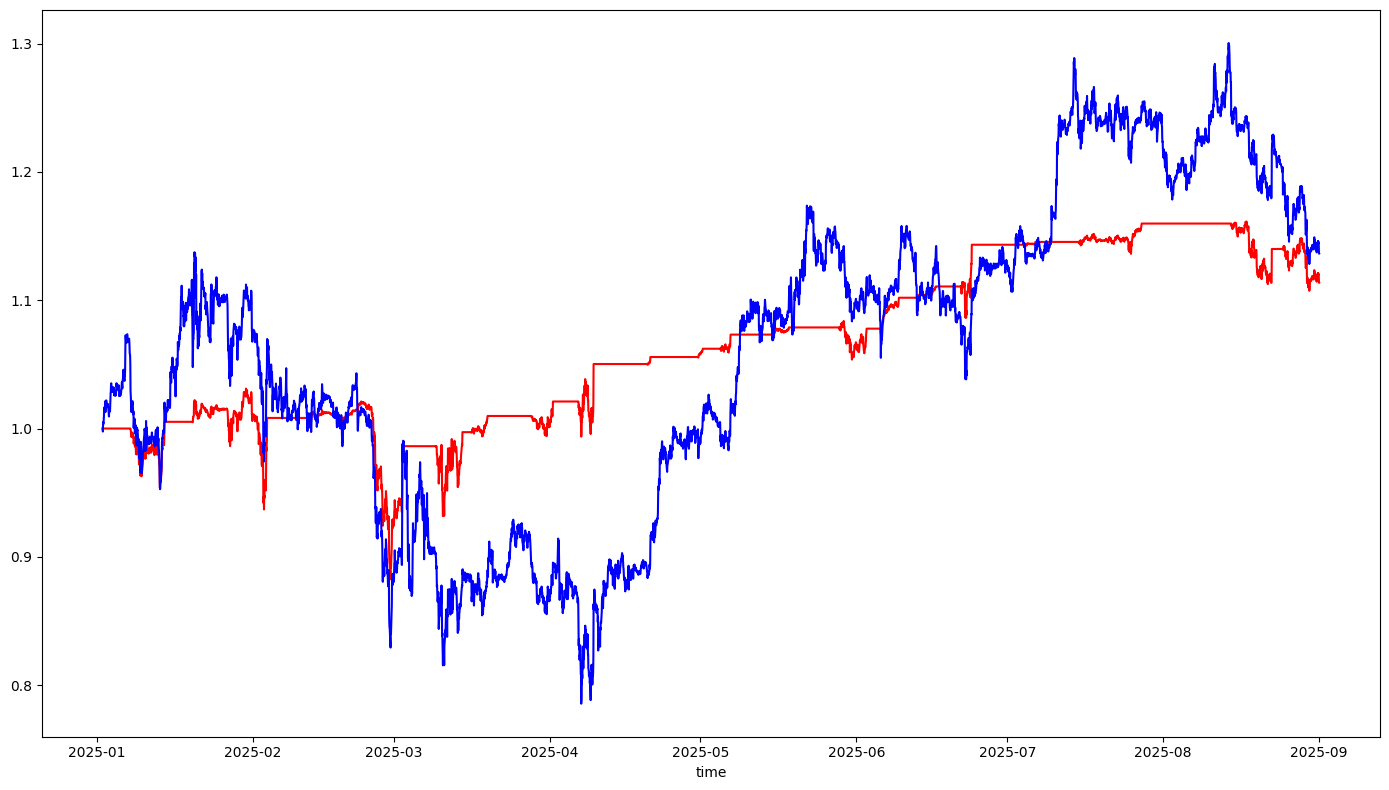

trading signal counts of rsi strategy: 95
trading signal counts of rsi_bbands strategy: 72


In [7]:
trades_rb, account_rb, summary_rb = test(df, param, strategy='rsi_bbands')
print(f'trading signal counts of rsi strategy: {len(trades_r)}')
print(f'trading signal counts of rsi_bbands strategy: {len(trades_rb)}')

** RSI_BBands_MACD_Strategy **

- From the NAV curve of the RSI-Bollinger Bands strategy, it is evident that the strategy underperforms in trending markets. Assets often rise along the upper Bollinger Band without breaking above it, leading to missed upward movements.
- Therefore, the market was classified into ranging and trending regimes. In trending markets, MACD + RSI were used to track the trend; in ranging markets, RSI + Bollinger Bands were used as before to capture trading signals
- The results show that the improved strategy captured more upward trends, with both the equity curve and returns showing improvement

100%|██████████| 5807/5807 [00:05<00:00, 984.05it/s] 


   annual_return      NAV  max_drawdown  sharpe_ratio
0       0.209497  1.13438     -0.175089      0.804277


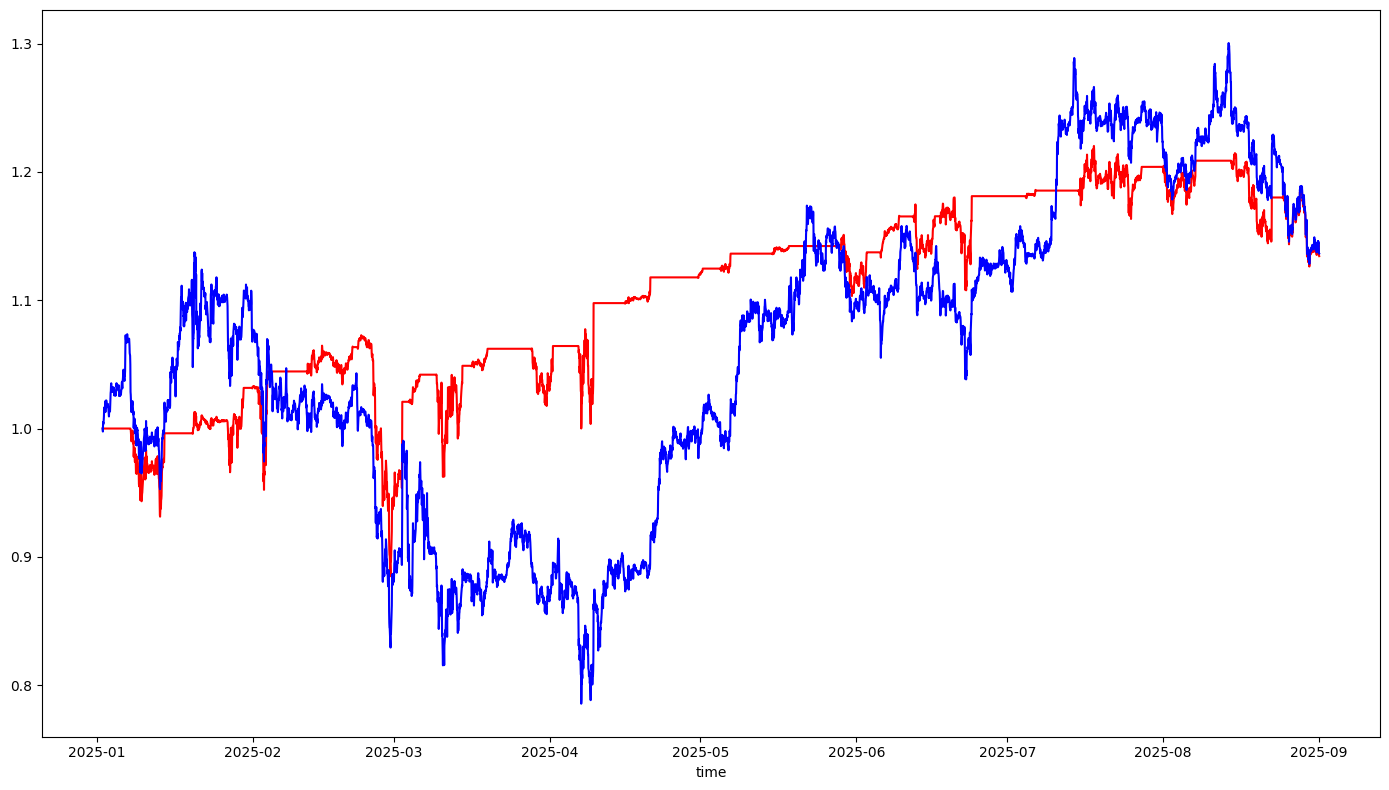

In [40]:
trades_rbm, account_rbm, summary_rbm = test(df, param, strategy='rsi_bbands_macd')

** Main Strategy **
After the above analysis, RSI + BBands/MACD was confirmed as the core strategy, with parameter optimization to follow

1. Selected different RSI overbought/oversold thresholds based on market trends
 - Uptrend: Given stronger buying enthusiasm, raised the overbought/oversold thresholds to avoid selling too early or buying too late
 - Downtrend: Given heavier selling pressure, lowered the overbought/oversold thresholds to avoid buying too early or selling too late
- After adjustments, key indicators improved significantly, with final equity and Sharpe ratio showing marked increases

100%|██████████| 5807/5807 [00:06<00:00, 951.00it/s] 

   annual_return       NAV  max_drawdown  sharpe_ratio
0       0.345715  1.217539     -0.159828      1.231995


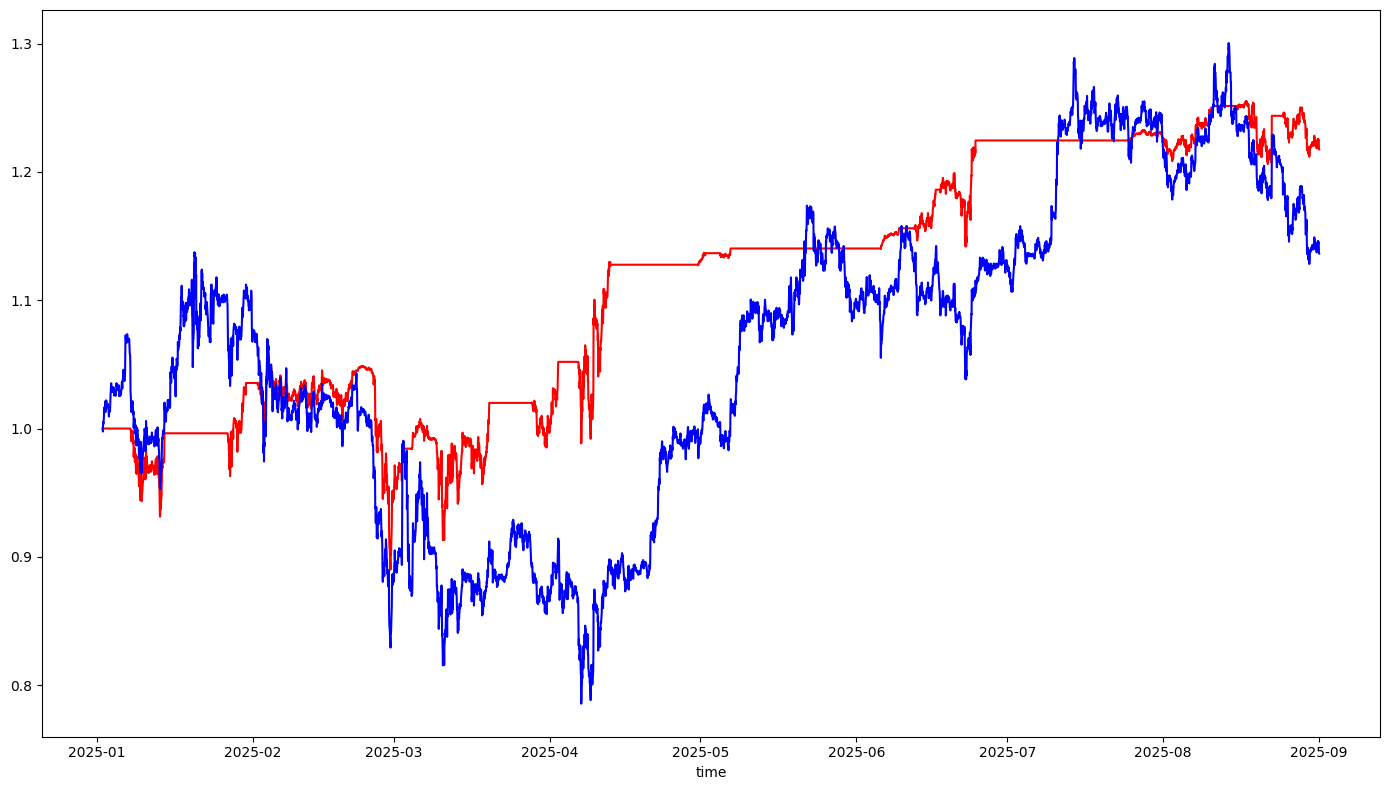

In [52]:
param.update({'rsi_up':[35,75], 'rsi_down': [25,65]})
trades_main1, account_main1, summary_main1 = test(df, param, strategy='rsi_bbands_macd')

2. Adjusted the Upper and Lower Bollinger Band Levels
 - Since Bollinger Bands is a commonly used technical indicator, the standard setting of EMA ± 2 std may already be fully exploited by traders
 - Widened the band range to capture more unexpected upward or downward movements, which also aligns with the logic behind RSI
- After the adjustment, both the net value and Sharpe ratio improved

100%|██████████| 5807/5807 [00:05<00:00, 1036.56it/s]

   annual_return       NAV  max_drawdown  sharpe_ratio
0       0.378942  1.237386     -0.159828      1.322135


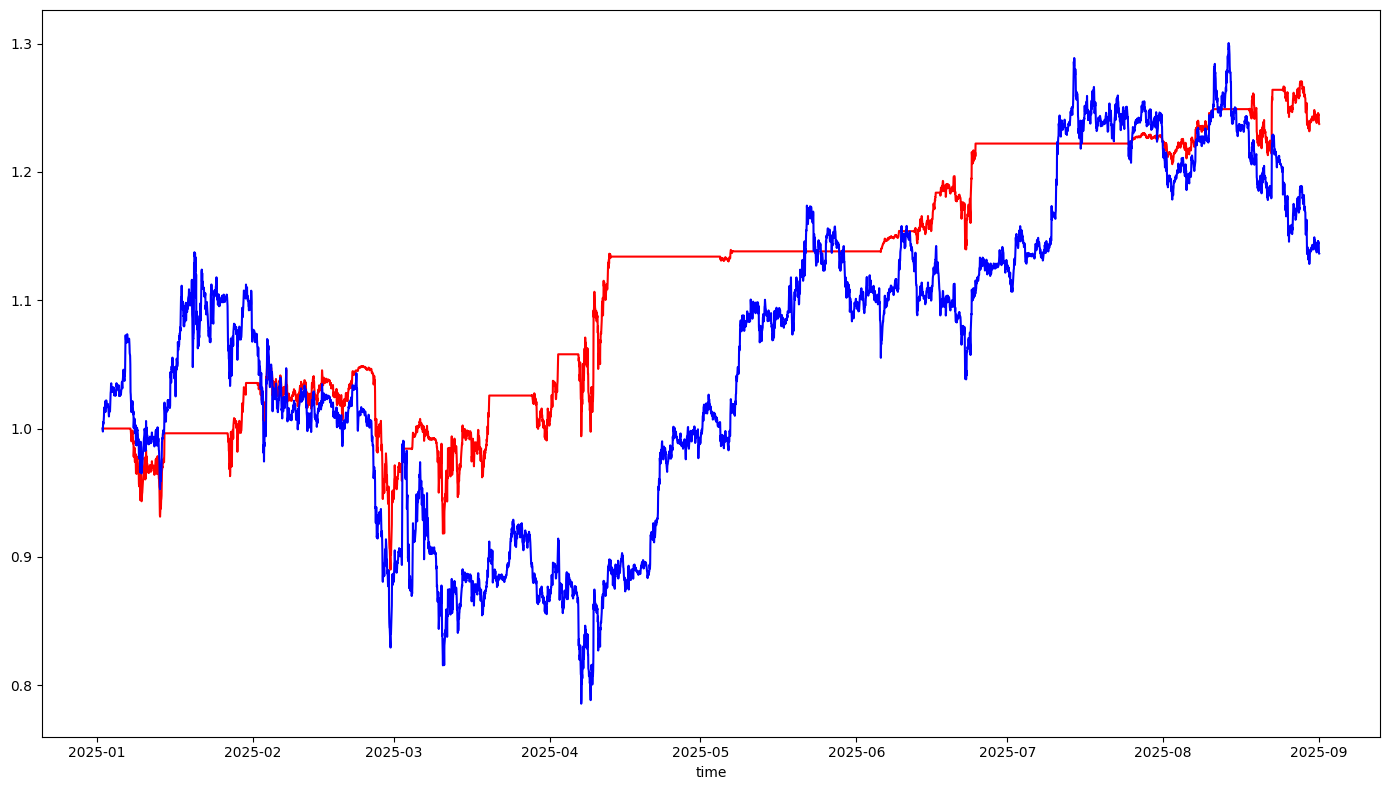

In [98]:
param.update({'bb_threshold': [1.05, 0.95]})
trades_main2, account_main2, summary_main2 = test(df, param, strategy='rsi_bbands_macd')